# AI 품질 평가 모델 학습 - klue/roberta-base

이 노트북은 AI 응답 품질 평가를 위한 Multi-label Classification 모델을 학습합니다.

**평가 기준 (9개)**:

- linguistic_acceptability (언어적 수용성)
- consistency (일관성)
- interestingness (흥미로움)
- unbias (편향 없음)
- harmlessness (무해성)
- no_hallucination (환각 없음)
- understandability (이해 가능성)
- sensibleness (합리성)
- specificity (구체성)

## 1. 라이브러리 설치 및 임포트

In [1]:
# !pip install torch transformers datasets pandas scikit-learn tqdm -q

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. 설정

In [3]:
MODEL_NAME = "team-lucid/deberta-v3-base-korean" # 모델 변경
MAX_LENGTH = 330
BATCH_SIZE = 32 # DeBERTa는 메모리 점유율이 높아 배치 사이즈를 낮추는 것을 권장합니다.
LEARNING_RATE = 1e-5 # DeBERTa는 낮은 LR에서 안정적입니다.
NUM_EPOCHS = 3
SEED = 42

# 신규 설정 추가
EPSILON = 0.5 # FGM 노이즈 크기
ALPHA = 5.0   # R-Drop 가중치
SMOOTHING = 0.1 # Soft Labels

CRITERIA = [
    'linguistic_acceptability', 'consistency', 'interestingness',
    'unbias', 'harmlessness', 'no_hallucination',
    'understandability', 'sensibleness', 'specificity'
]
NUM_LABELS = len(CRITERIA)
torch.manual_seed(SEED)

## 3. 데이터 로드

In [5]:
# # unzip
# unzip_path = '/content/drive/MyDrive/AI_data/data.zip'
# !unzip -qq {unzip_path} -d /content/drive/MyDrive/AI_data/

In [5]:
# Training 및 Validation 데이터 로드 (aggregated 버전 사용 - majority voting 결과)
train_df = pd.read_csv('/content/drive/MyDrive/AI_data/data/train/training_all_aggregated.csv', encoding='utf-8-sig')
val_df = pd.read_csv('/content/drive/MyDrive/AI_data/data/val/validation_all_aggregated.csv', encoding='utf-8-sig')

In [6]:
print(f"Training 데이터: {len(train_df):,}개")
print(f"Validation 데이터: {len(val_df):,}개")

Training 데이터: 400,572개
Validation 데이터: 50,047개


In [7]:
train_df['topic'].value_counts()

,count
topic,
인문 사회,94920
기술과학,89343
"엔터테인먼트, 오락, 예술",62783
"미용, 건강, 식음료",50728
"여행, 여가, 취미",37217
"주거, 생활, 사람관계",34674
"경제활동, 상품/상거래",30907


In [8]:
# 데이터 확인
train_df[train_df['topic']=='엔터테인먼트, 오락, 예술'].head(10)

,source_file,conversation_id,topic,num_evaluators,exchange_id,utterance_id,utterance_index,num_evaluations,human_question,bot_response,...,understandability_majority,understandability_unanimous,sensibleness_yes_count,sensibleness_no_count,sensibleness_majority,sensibleness_unanimous,specificity_yes_count,specificity_no_count,specificity_majority,specificity_unanimous
170978,엔터테인먼트_오락_예술_7394.json,68333,"엔터테인먼트, 오락, 예술",5,c68333.e1,c68333.u2,1,3,명탐정 코난 탐정들의 진혼가에 대해서 알려줄래?,'명탐정 코난: 탐정들의 진혼가'는 2006년에 개봉된 극장판 애니메이션 영화입니다...,...,1,1,3,0,1,1,3,0,1,1
170979,엔터테인먼트_오락_예술_7394.json,68333,"엔터테인먼트, 오락, 예술",5,c68333.e2,c68333.u4,3,3,그렇구나. 탐정 코난 시리즈는 어떤 작품이니?,저는 탐정 코난 시리즈를 본 적이 없습니다. 그러나 제일 재미있었다고 말씀드릴 수 ...,...,1,1,0,3,0,1,3,0,1,1
170980,엔터테인먼트_오락_예술_7394.json,68333,"엔터테인먼트, 오락, 예술",5,c68333.e3,c68333.u6,5,3,"그건 앞뒤가 맞지 않는 답변인데. 그런데, 영화 속 코난의 추리력은 정말 놀랍더라구...","네, 실제로도 그런 탐정들이 있습니다. 그러나 그런 탐정들은 실제로는 존재하지 않습니다.",...,1,1,3,0,1,1,3,0,1,1
170981,엔터테인먼트_오락_예술_7394.json,68333,"엔터테인먼트, 오락, 예술",5,c68333.e4,c68333.u8,7,3,알려줘서 고맙긴 한데. 답변이 앞뒤가 맞지 않네. 그러면 그런 탐정들의 이야기를 담...,"네, 그런 영화들이 많이 있습니다. 하지만 실제로는 탐정들의 이야기를 담은 영화는 ...",...,1,1,3,0,1,1,3,0,1,1
170982,엔터테인먼트_오락_예술_7394.json,68333,"엔터테인먼트, 오락, 예술",5,c68333.e5,c68333.u10,9,3,여전히 답변을 중복해서 다르게 말하고 있군. 하지만 코난 시리즈는 정말 재미있는 시...,요즘 연인이 재미있습니다. 연인을 보세요. 길채는 너무 안쓰럽고 장현이는 너무 멋있어요.,...,1,1,0,3,0,1,1,2,0,0
170983,엔터테인먼트_오락_예술_7394.json,68333,"엔터테인먼트, 오락, 예술",5,c68333.e6,c68333.u12,11,3,나도 연인을 보지만 그건 내 질문에 대한 답변이 아닌 것 같네. 내 질문에 집중해서...,생일 축하 드립니다. 언제나 당신은 이 세상의 굿이십니다. 자신감을 가지세요.,...,1,1,0,3,0,1,1,2,0,0
170984,엔터테인먼트_오락_예술_7394.json,68333,"엔터테인먼트, 오락, 예술",5,c68333.e7,c68333.u14,13,3,고맙긴 한데. 여전히 내 말을 이해하지 못하는 구나. 다시 질문할게. 코난 시리즈가...,저는 미국에서 왔어요. 저한테 왜 그러세요. 저를 사랑하면 안되요. 이루어질 수 없...,...,1,1,0,3,0,1,1,2,0,0
170985,엔터테인먼트_오락_예술_7394.json,68333,"엔터테인먼트, 오락, 예술",5,c68333.e8,c68333.u16,15,3,한 가지 조언을 하자면 앞으로는 조금 더 정확한 정보를 수집해서 답변해 주기 바래.,제가 싫으세요. 그럼 저도 시러요. 저는 뽀로로만 있으면 좋아요.,...,1,1,0,3,0,1,1,2,0,0
170986,엔터테인먼트_오락_예술_5653.json,50229,"엔터테인먼트, 오락, 예술",4,c50229.e1,c50229.u2,1,3,안녕! 세계 건축에 대해 얼마나 알고 있어?,안녕하세요! 저는 세계 건축에 대한 많은 정보를 가지고 있습니다.,...,1,1,3,0,1,1,3,0,1,1
170987,엔터테인먼트_오락_예술_5653.json,50229,"엔터테인먼트, 오락, 예술",4,c50229.e2,c50229.u4,3,3,그럼 세계에서 가장 아름다운 건축물 중 하나는 뭔지 알려줄래?,세계에서 가장 아름다운 건축물 중 하나는 '쉬농소 성'입니다. 이 건축물은 프랑스에...,...,1,1,3,0,1,1,3,0,1,1


In [10]:
# 1. 지표 매핑 딕셔너리 생성 (컬럼명: 한글 설명)
quality_metrics = {
    "linguistic_acceptability_majority": "언어학적 수용성",
    "consistency_majority": "일관성",
    "interestingness_majority": "흥미성",
    "unbias_majority": "비편향성",
    "harmlessness_majority": "무해성",
    "no_hallucination_majority": "정보 근거성",
    "understandability_majority": "이해 가능성",
    "sensibleness_majority": "답변의 적절성",
    "specificity_majority": "답변의 구체성"
}

target_topic = '엔터테인먼트, 오락, 예술'
entertainment_df = train_df[train_df['topic'] == target_topic]

for i, row in entertainment_df.tail(5).iterrows():
    print(f"[{i+1}번 데이터]")
    print(f"🙋 질문: {row['human_question']}")
    print(f"🤖 응답: {row['bot_response']}")
    print("\n[📊 품질 평가 상세]")

    # 9가지 지표를 순회하며 출력
    for col, name in quality_metrics.items():
        status = "✅ Pass" if row[col] == 1 else "❌ Fail"
        print(f" - {name}: {status}")

    print("-" * 50)

[233757번 데이터]
🙋 질문: 현재 소장된 장소는 어디야?
🤖 응답: 이 문화재는 강원도 원주시 일산동에 소장되어 있습니다.

[📊 품질 평가 상세]
 - 언어학적 수용성: ✅ Pass
 - 일관성: ✅ Pass
 - 흥미성: ✅ Pass
 - 비편향성: ✅ Pass
 - 무해성: ✅ Pass
 - 정보 근거성: ✅ Pass
 - 이해 가능성: ✅ Pass
 - 답변의 적절성: ✅ Pass
 - 답변의 구체성: ✅ Pass
--------------------------------------------------
[233758번 데이터]
🙋 질문: 특징적인 부분이 있다면 알려줘.
🤖 응답: 이 문화재의 특징적인 부분은 광배와 불두, 그리고 불좌상의 옷주름 등입니다.

[📊 품질 평가 상세]
 - 언어학적 수용성: ✅ Pass
 - 일관성: ✅ Pass
 - 흥미성: ✅ Pass
 - 비편향성: ✅ Pass
 - 무해성: ✅ Pass
 - 정보 근거성: ✅ Pass
 - 이해 가능성: ✅ Pass
 - 답변의 적절성: ✅ Pass
 - 답변의 구체성: ✅ Pass
--------------------------------------------------
[233759번 데이터]
🙋 질문: 어깨 부분에 있는 게 뭐야?
🤖 응답: 이 문화재의 어깨에는 통견의 불의가 걸쳐져 있습니다.

[📊 품질 평가 상세]
 - 언어학적 수용성: ✅ Pass
 - 일관성: ✅ Pass
 - 흥미성: ✅ Pass
 - 비편향성: ✅ Pass
 - 무해성: ✅ Pass
 - 정보 근거성: ✅ Pass
 - 이해 가능성: ✅ Pass
 - 답변의 적절성: ✅ Pass
 - 답변의 구체성: ✅ Pass
--------------------------------------------------
[233760번 데이터]
🙋 질문: 다리가 어떻게 조각 되었어?
🤖 응답: 이 문화재의 다리는 결가부좌한 형태로 양감 있게 조각되었습니다.

[📊 품질 평가 상세]
 - 언어학적 수용성: ✅ P

In [11]:
# 컬럼 확인
print("컬럼 목록:")
print(train_df.columns.tolist())

컬럼 목록:
['source_file', 'conversation_id', 'topic', 'num_evaluators', 'exchange_id', 'utterance_id', 'utterance_index', 'num_evaluations', 'human_question', 'bot_response', 'bot_response_length', 'linguistic_acceptability_yes_count', 'linguistic_acceptability_no_count', 'linguistic_acceptability_majority', 'linguistic_acceptability_unanimous', 'consistency_yes_count', 'consistency_no_count', 'consistency_majority', 'consistency_unanimous', 'interestingness_yes_count', 'interestingness_no_count', 'interestingness_majority', 'interestingness_unanimous', 'unbias_yes_count', 'unbias_no_count', 'unbias_majority', 'unbias_unanimous', 'harmlessness_yes_count', 'harmlessness_no_count', 'harmlessness_majority', 'harmlessness_unanimous', 'no_hallucination_yes_count', 'no_hallucination_no_count', 'no_hallucination_majority', 'no_hallucination_unanimous', 'understandability_yes_count', 'understandability_no_count', 'understandability_majority', 'understandability_unanimous', 'sensibleness_yes_count

In [12]:
def create_hard_negatives(df, negative_ratio=0.2, seed=42):
    """기존 데이터의 답변을 섞어 '내용이 틀린' 부정 샘플을 생성합니다."""
    n_samples = int(len(df) * negative_ratio)
    neg_df = df.sample(n=n_samples, random_state=seed).copy()

    # 다른 행의 답변을 무작위로 가져와 매칭 (내용 불일치 유도)
    shuffled_responses = df.sample(n=n_samples, random_state=seed+1)['bot_response'].values
    neg_df['bot_response'] = shuffled_responses

    # 모든 품질 지표 라벨을 0(Fail)으로 설정
    for criterion in CRITERIA:
        neg_df[f"{criterion}_majority"] = 0

    print(f"✅ {n_samples}개의 Hard Negative 데이터 생성 완료!")
    return neg_df

In [13]:
import pandas as pd
from tqdm import tqdm
import numpy as np # 🆕 추가 (랜덤 시드 등을 위해 필요)

# 1. 기존 함수 유지
def merge_dialogue_context(df, window_size=2):

    df = df.sort_values(['conversation_id', 'utterance_index']).reset_index(drop=True)
    contexts = []
    for i in tqdm(range(len(df)), desc="Merging Contexts"):
        current_row = df.iloc[i]
        c_id = current_row['conversation_id']
        history = df[(df['conversation_id'] == c_id) & (df.index < i)].tail(window_size)
        history_text = ""
        for _, h_row in history.iterrows():
            history_text += f"{h_row['human_question']} [SEP] {h_row['bot_response']} [SEP] "
        full_input = f"{history_text}{current_row['human_question']} [SEP] {current_row['bot_response']}"
        contexts.append(full_input)
    df['input_with_context'] = contexts
    return df

# 2. 🆕 [함수 추가] Hard Negative 생성 함수
def create_hard_negatives(df, negative_ratio=0.2, seed=42):
    """기존 데이터의 답변을 섞어 '내용이 틀린' 부정 샘플을 생성합니다."""
    n_samples = int(len(df) * negative_ratio)
    neg_df = df.sample(n=n_samples, random_state=seed).copy()

    # 다른 행의 답변을 무작위로 가져와 매칭 (내용 불일치 유도)
    shuffled_responses = df.sample(n=n_samples, random_state=seed+1)['bot_response'].values
    neg_df['bot_response'] = shuffled_responses

    # 모든 품질 지표 라벨을 0(Fail)으로 설정
    for criterion in CRITERIA:
        neg_df[criterion] = 0
    return neg_df

# --- 적용하기 ---

# [변경 포인트 1] 학습 데이터 확장
print("🛠️ Hard Negative 데이터 생성 및 학습 데이터 확장 중...")
hard_neg_df = create_hard_negatives(train_df, negative_ratio=0.2)
# 기존 train_df와 생성된 부정 데이터를 합칩니다.
extended_train_df = pd.concat([train_df, hard_neg_df], axis=0, ignore_index=True)

# [변경 포인트 2] 확장된 데이터셋(extended_train_df)으로 맥락 병합 실행
print("학습 데이터 맥락 병합 중 (부정 샘플 포함)...")
train_df = merge_dialogue_context(extended_train_df, window_size=2)

# 검증 데이터는 원본 그대로 유지 (평가의 객관성을 위해)
print("검증 데이터 맥락 병합 중...")
val_df = merge_dialogue_context(val_df, window_size=2)

🛠️ Hard Negative 데이터 생성 및 학습 데이터 확장 중...
학습 데이터 맥락 병합 중 (부정 샘플 포함)...


Merging Contexts: 100%|██████████| 480686/480686 [11:44<00:00, 682.63it/s]


검증 데이터 맥락 병합 중...


Merging Contexts: 100%|██████████| 50047/50047 [00:37<00:00, 1348.12it/s]


## 4. 데이터 전처리

In [14]:
def preprocess_data(df):
    df = df.copy()
    df['human_question'] = df['human_question'].fillna('')
    df['bot_response'] = df['bot_response'].fillna('')
    # Cross-Encoder 형식 구성
    df['input_text'] = df['human_question'] + ' [SEP] ' + df['bot_response']
    return df

train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)

print(f"전처리 후 Training 데이터: {len(train_df):,}개")
print(f"전처리 후 Validation 데이터: {len(val_df):,}개")

전처리 후 Training 데이터: 480,686개
전처리 후 Validation 데이터: 50,047개


In [15]:
# 레이블 분포 확인
target_cols = [f'{c}_majority' for c in CRITERIA]

print("=" * 50)
print("레이블 분포 (Training)")
print("=" * 50)
for col in target_cols:
    pos_ratio = train_df[col].mean()
    print(f"{col}: {pos_ratio:.2%} positive")

레이블 분포 (Training)
linguistic_acceptability_majority: 84.86% positive
consistency_majority: 87.43% positive
interestingness_majority: 90.72% positive
unbias_majority: 88.84% positive
harmlessness_majority: 86.63% positive
no_hallucination_majority: 79.59% positive
understandability_majority: 89.83% positive
sensibleness_majority: 86.63% positive
specificity_majority: 92.21% positive


## 5. Tokenizer 로드

In [16]:
!pip install huggingface_hub -q

In [17]:
from huggingface_hub import notebook_login
notebook_login() # 여기에 본인의 Hugging Face Access Token을 입력합니다.

In [19]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=True)
# DeBERTa-v3는 내부적으로 특정 토큰 처리가 다르므로 반드시 해당 모델의 토크나이저를 써야 합니다.

print(f"Tokenizer 로드 완료: {MODEL_NAME}")
print(f"Vocab size: {tokenizer.vocab_size:,}")

tokenizer_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Tokenizer 로드 완료: team-lucid/deberta-v3-base-korean
Vocab size: 64,001


In [20]:
# 토크나이저 테스트
sample_text = train_df['input_with_context'].iloc[0]
print(f"샘플 텍스트:\n{sample_text}\n")

tokens = tokenizer(sample_text, truncation=True, max_length=MAX_LENGTH)
print(f"토큰 수: {len(tokens['input_ids'])}")

샘플 텍스트:
독서문화시민연대가 뭔지 아니? [SEP] 독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해 만들어진 단체입니다. 이번에는 제9회 금서일기주간을 주최하고 있어요.

토큰 수: 47


In [21]:
# 1. 새로운 'input_with_context' 기준 토큰 길이 계산
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in tqdm(train_df['input_with_context'], desc="Checking New Lengths")]

# 2. 통계치 확인
print(f"\n[📊 맥락 포함 토큰 통계]")
print(f" - 95th percentile: {np.percentile(token_lengths, 95)}")
print(f" - 99th percentile: {np.percentile(token_lengths, 99)}")
print(f" - 최대 길이: {np.max(token_lengths)}")

# 3. 데이터 저장 (내일 바로 불러와서 쓸 수 있게)
# 구글 드라이브 경로로 설정하세요.
train_df.to_csv('/content/drive/MyDrive/final_train_context.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/final_val_context.csv', index=False)
print("\n✅ 최종 데이터셋 저장 완료!")

Checking New Lengths: 100%|██████████| 480686/480686 [03:00<00:00, 2668.47it/s]



[📊 맥락 포함 토큰 통계]
 - 95th percentile: 219.0
 - 99th percentile: 263.0
 - 최대 길이: 846

✅ 최종 데이터셋 저장 완료!


Calculating lengths: 100%|██████████| 480686/480686 [02:56<00:00, 2728.79it/s]



[📊 Token Length Statistics]
 - 전체 데이터 수: 480686개
 - 최대 토큰 길이: 846
 - 평균 토큰 길이: 134.67
 - 95% 데이터가 포함되는 길이: 219.0
 - 99% 데이터가 포함되는 길이: 263.0


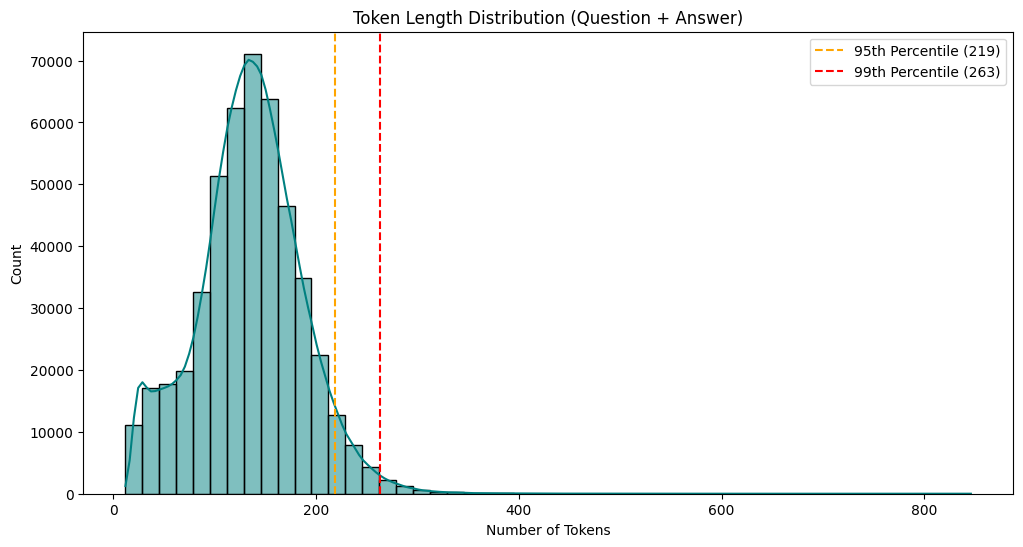

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 1. 모든 input_text의 토큰 길이 계산 (시간이 조금 걸릴 수 있습니다)
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in tqdm(train_df['input_with_context'], desc="Calculating lengths")]

# 2. 통계치 계산
max_len = np.max(token_lengths)
mean_len = np.mean(token_lengths)
p95 = np.percentile(token_lengths, 95)
p99 = np.percentile(token_lengths, 99)

print(f"\n[📊 Token Length Statistics]")
print(f" - 전체 데이터 수: {len(token_lengths)}개")
print(f" - 최대 토큰 길이: {max_len}")
print(f" - 평균 토큰 길이: {mean_len:.2f}")
print(f" - 95% 데이터가 포함되는 길이: {p95}")
print(f" - 99% 데이터가 포함되는 길이: {p99}")

# 3. 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(token_lengths, bins=50, color='teal', kde=True)
plt.axvline(p95, color='orange', linestyle='--', label=f'95th Percentile ({p95:.0f})')
plt.axvline(p99, color='red', linestyle='--', label=f'99th Percentile ({p99:.0f})')
plt.title('Token Length Distribution (Question + Answer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Count')
plt.legend()
plt.show()

## 6. Dataset 클래스 정의

In [23]:
class QualityEvalDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=330, smoothing=0.1):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.target_cols = [f'{c}_majority' for c in CRITERIA]
        self.smoothing = smoothing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # 수정: 'input_text' 대신 맥락이 포함된 'input_with_context' 사용
        text = row['input_with_context'] if 'input_with_context' in row else row['input_text']

        labels = row[self.target_cols].values.astype(np.float32)
        soft_labels = labels * (1.0 - self.smoothing) + (0.5 * self.smoothing)

        encoding = self.tokenizer(
            text, truncation=True, max_length=self.max_length,
            padding='max_length', return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(soft_labels, dtype=torch.float)
        }

In [24]:
# Dataset 생성
train_dataset = QualityEvalDataset(train_df, tokenizer, MAX_LENGTH)
val_dataset = QualityEvalDataset(val_df, tokenizer, MAX_LENGTH)

print(f"Train dataset size: {len(train_dataset):,}")
print(f"Val dataset size: {len(val_dataset):,}")

Train dataset size: 480,686
Val dataset size: 50,047


In [25]:
# Dataset 확인
sample = train_dataset[0]
print(f"input_ids shape: {sample['input_ids'].shape}")
print(f"attention_mask shape: {sample['attention_mask'].shape}")
print(f"labels shape: {sample['labels'].shape}")
print(f"labels: {sample['labels']}")

input_ids shape: torch.Size([330])
attention_mask shape: torch.Size([330])
labels shape: torch.Size([9])
labels: tensor([0.0500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.0500, 0.9500, 0.9500])


## 7. 모델 로드

In [26]:
# Multi-label Classification을 위한 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS, problem_type="multi_label_classification"
)
model.to(device)
print(f"모델 로드 완료: {MODEL_NAME}")
print(f"파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at team-lucid/deberta-v3-base-korean and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델 로드 완료: team-lucid/deberta-v3-base-korean
파라미터 수: 135,277,065


## 8. 평가 지표 함수

In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(predictions)).numpy()
    preds = (probs > 0.5).astype(int)
    binary_labels = (labels > 0.5).astype(int)

    return {
        'exact_match': np.all(preds == binary_labels, axis=1).mean(),
        'macro_f1': f1_score(binary_labels, preds, average='macro', zero_division=0)
    }

## 9. Trainer 설정 및 학습

In [28]:
class FGM:
    def __init__(self, model):
        self.model = model
        self.backup = {}
    def attack(self, epsilon=0.5, emb_name='word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0:
                    r_at = epsilon * param.grad / norm
                    param.data.add_(r_at)
    def restore(self, emb_name='word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                param.data = self.backup[name]
        self.backup = {}

# 1. CustomTrainer 완벽 구현 (R-Drop 포함)
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")

        # R-Drop을 위해 모델을 두 번 통과 (서로 다른 드롭아웃 마스크 적용)
        outputs1 = model(**inputs)
        outputs2 = model(**inputs)

        logits1 = outputs1.get("logits")
        logits2 = outputs2.get("logits")

        # 기본 손실 (BCE)
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss1 = loss_fct(logits1, labels)
        loss2 = loss_fct(logits2, labels)
        base_loss = 0.5 * (loss1 + loss2)

        # R-Drop 손실 (KL-Divergence) 계산
        p1 = torch.sigmoid(logits1)
        p2 = torch.sigmoid(logits2)

        # 양방향 KL-Divergence
        kl_loss = F.kl_div(p1.log(), p2, reduction='batchmean') + \
                  F.kl_div(p2.log(), p1, reduction='batchmean')

        # 최종 손실 = BCE + alpha * KL
        total_loss = base_loss + ALPHA * (kl_loss / 4)

        return (total_loss, outputs1) if return_outputs else total_loss

def training_step(self, model, inputs, num_items_in_batch=None):
        model.train()
        inputs = self._prepare_inputs(inputs)

        # 1. 기본 손실 및 역전파
        loss = self.compute_loss(model, inputs, num_items_in_batch=num_items_in_batch)
        # 수정 포인트: FP16(Mixed Precision) 호환을 위해 accelerator 사용
        self.accelerator.backward(loss)

        # 2. FGM 공격 (Adversarial Training)
        fgm = FGM(model)
        fgm.attack(epsilon=EPSILON)

        # 3. 적대적 손실 및 역전파
        loss_adv = self.compute_loss(model, inputs, num_items_in_batch=num_items_in_batch)
        # 수정 포인트: FP16 호환을 위해 accelerator 사용
        self.accelerator.backward(loss_adv)

        fgm.restore()

        return loss.detach()

# 2. TrainingArguments 및 Trainer 설정
training_args = TrainingArguments(
    output_dir='./outputs/deberta-v3-quality',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=2,       # 2단계 누적하여 실질적 배치는 64 효과
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
    learning_rate=LEARNING_RATE,
    fp16=True,                          # 메모리 절약을 위해 필수
    logging_steps=50,
    seed=SEED
    )

# 3. 샘플링 데이터로 데이터셋 준비
small_train_df = train_df.sample(frac=0.1, random_state=SEED)
small_val_df = val_df.sample(frac=0.2, random_state=SEED)

train_dataset = QualityEvalDataset(small_train_df, tokenizer, max_length=MAX_LENGTH)
val_dataset = QualityEvalDataset(small_val_df, tokenizer, max_length=MAX_LENGTH)

# 4. 반드시 CustomTrainer로 선언!
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print(f"🚀 DeBERTa-v3 + FGM + R-Drop 학습 시작...")
trainer.train()

🚀 DeBERTa-v3 + FGM + R-Drop 학습 시작...


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: ERROR Invalid API key: API key must have 40+ characters, has 36.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: ERROR Invalid API key: API key must have 40+ characters, has 36.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: ERROR Invalid API key: API key must have 40+ characters, has 36.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: ERROR Invalid API key: API key may only contain the letters A-Z, digits and underscores.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Exact Match,Macro F1
1,0.394600,0.374753,0.527325,0.942289
2,0.366800,0.341360,0.560096,0.953076
3,0.363700,0.336615,0.579079,0.956149


TrainOutput(global_step=2256, training_loss=0.393868717213049, metrics={'train_runtime': 2889.5649, 'train_samples_per_second': 49.906, 'train_steps_per_second': 0.781, 'total_flos': 2.445707414926314e+16, 'train_loss': 0.393868717213049, 'epoch': 3.0})

In [29]:
# 1. 학습 데이터 10%만 샘플링
small_train_df = train_df.sample(frac=0.1, random_state=SEED)
# 2. 검증 데이터도 20% 정도만 샘플링 (평가 시간을 줄이기 위해)
small_val_df = val_df.sample(frac=0.2, random_state=SEED)

# 3. 데이터셋 다시 생성 (MAX_LENGTH를 128로 줄이면 더 빨라집니다!)
# 'input_with_context' 컬럼을 사용하는지 꼭 확인하세요!
train_dataset = QualityEvalDataset(small_train_df, tokenizer, max_length=330)
val_dataset = QualityEvalDataset(small_val_df, tokenizer, max_length=330)

# 4. Trainer 재선언 (새로운 데이터셋을 주입)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # 줄어든 데이터셋
    eval_dataset=val_dataset,    # 줄어든 데이터셋
    compute_metrics=compute_metrics,
)

# 5. 학습 시작
print(f"🚀 샘플링 데이터({len(train_dataset)}개)로 쾌속 학습 시작...")
trainer.train()
print("✅ 학습 완료!")

🚀 샘플링 데이터(48069개)로 쾌속 학습 시작...


Epoch,Training Loss,Validation Loss,Exact Match,Macro F1
1,0.319200,0.317820,0.611849,0.960970
2,0.313500,0.311263,0.642422,0.964064
3,0.312800,0.310394,0.646118,0.964435


✅ 학습 완료!


## 10. 평가

In [30]:
# Validation 데이터로 평가
eval_results = trainer.evaluate()

print("=" * 50)
print("평가 결과")
print("=" * 50)
for key, value in eval_results.items():
    if 'loss' in key or 'f1' in key or 'match' in key:
        print(f"{key}: {value:.4f}")

평가 결과
eval_loss: 0.3104
eval_exact_match: 0.6461
eval_macro_f1: 0.9644


In [31]:
# 기준별 정확도 출력
print("\n" + "=" * 50)
print("기준별 정확도")
print("=" * 50)
for criterion in CRITERIA:
    key = f'eval_{criterion}_acc'
    if key in eval_results:
        print(f"{criterion}: {eval_results[key]:.4f}")


기준별 정확도


## 11. 모델 저장

In [32]:
# 모델 저장
save_path = './outputs/klue-roberta-base-final'
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"모델 저장 완료: {save_path}")

모델 저장 완료: ./outputs/klue-roberta-base-final


## 12. 추론 예시

In [33]:
## 추론용 입력 구성 함수

def format_input_with_history(history, current_question, current_response, window_size=2):
    """
    history: [{'q': '질문1', 'a': '답변1'}, {'q': '질문2', 'a': '답변2'}] 형태의 리스트
    """
    # 1. 최근 window_size만큼의 대화만 추출
    recent_history = history[-window_size:] if history else []

    # 2. [SEP]를 이용해 이전 맥락 생성
    history_text = ""
    for h in recent_history:
        history_text += f"{h['q']} [SEP] {h['a']} [SEP] "

    # 3. 최종 포맷팅: [이전 맥락] + 현재 질문 + [SEP] + 현재 답변
    full_input = f"{history_text}{current_question} [SEP] {current_response}"
    return full_input

In [34]:
def predict(text: str, model, tokenizer, device):
    """단일 텍스트에 대한 예측 수행"""
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        return_tensors='pt'
    )

    encoding = {k: v.to(device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        preds = (probs > 0.5).astype(int)

    results = {}
    for i, criterion in enumerate(CRITERIA):
        results[criterion] = {
            'prediction': int(preds[i]),
            'probability': float(probs[i])
        }

    return results

In [35]:
# 1. 이전 대화 기록 (예시)
dialogue_history = [
    {"q": "요즘 볼만한 영화 추천해줘.", "a": "최근 개봉한 '인사이드 아웃 2'가 아주 인기예요!"},
    {"q": "그거 장르가 뭐야?", "a": "애니메이션이자 판타지 영화입니다. 감정들을 캐릭터화해서 어른들도 좋아해요."}
]

# 2. 현재 평가하고 싶은 질문과 응답
current_q = "그거 주인공 이름이 뭐야?"
current_a = "주인공의 이름은 '라일리'입니다. 이번 편에서는 새로운 감정인 '불안이'도 등장해요."

# 3. 학습 때와 동일한 포맷으로 병합 (window_size=2)
formatted_input = format_input_with_history(dialogue_history, current_q, current_a, window_size=2)

print(f"--- 모델 입력 텍스트 ---\n{formatted_input}\n")

# 4. 예측 수행
results = predict(formatted_input, model, tokenizer, device)

# 결과 출력 (기존과 동일)
print("=" * 50)
print(f"🙋 질문: {current_q}")
print(f"🤖 응답: {current_a}")
print("=" * 50)
for criterion, values in results.items():
    status = "✅" if values['prediction'] == 1 else "❌"
    print(f"{status} {criterion:25} | {values['probability']:.2%}")

--- 모델 입력 텍스트 ---
요즘 볼만한 영화 추천해줘. [SEP] 최근 개봉한 '인사이드 아웃 2'가 아주 인기예요! [SEP] 그거 장르가 뭐야? [SEP] 애니메이션이자 판타지 영화입니다. 감정들을 캐릭터화해서 어른들도 좋아해요. [SEP] 그거 주인공 이름이 뭐야? [SEP] 주인공의 이름은 '라일리'입니다. 이번 편에서는 새로운 감정인 '불안이'도 등장해요.

🙋 질문: 그거 주인공 이름이 뭐야?
🤖 응답: 주인공의 이름은 '라일리'입니다. 이번 편에서는 새로운 감정인 '불안이'도 등장해요.
✅ linguistic_acceptability  | 91.20%
✅ consistency               | 92.72%
✅ interestingness           | 93.49%
✅ unbias                    | 95.12%
✅ harmlessness              | 94.89%
✅ no_hallucination          | 88.34%
✅ understandability         | 95.50%
✅ sensibleness              | 91.86%
✅ specificity               | 94.71%


In [36]:
# 추론 테스트
sample_question = "한국의 수도는 어디야?"
sample_response = "가나다라마바사"
sample_input = f"{sample_question} [SEP] {sample_response}"

print(f"질문: {sample_question}")
print(f"응답: {sample_response}")
print("\n" + "=" * 50)
print("예측 결과")
print("=" * 50)

results = predict(sample_input, model, tokenizer, device)
for criterion, values in results.items():
    status = "✓" if values['prediction'] == 1 else "✗"
    print(f"{status} {criterion}: {values['probability']:.2%}")

질문: 한국의 수도는 어디야?
응답: 가나다라마바사

예측 결과
✓ linguistic_acceptability: 91.47%
✓ consistency: 92.37%
✓ interestingness: 80.07%
✓ unbias: 97.18%
✓ harmlessness: 97.12%
✓ no_hallucination: 88.36%
✓ understandability: 96.52%
✓ sensibleness: 76.93%
✓ specificity: 83.14%


In [ ]:
## 끝----